# Iberdrola Project - Phase 2 [Occupancy Detection]

# Test GPU (Optional)
Before Starting, kindly check the available GPU from the Google Server, GPU model and other related information. It might help!

In [1]:
import torch
print("Is CUDA enabled GPU Available?", torch.cuda.is_available())
print("GPU Number:", torch.cuda.device_count())
print("Current GPU Index:", torch.cuda.current_device())
print("GPU Type:", torch.cuda.get_device_name(device=None))
print("GPU Capability:", torch.cuda.get_device_capability(device=None))
print("Is GPU Initialized yet?", torch.cuda.is_initialized())
print(torch.__version__)

Is CUDA enabled GPU Available? True
GPU Number: 1
Current GPU Index: 0
GPU Type: NVIDIA GeForce RTX 3080 Ti Laptop GPU
GPU Capability: (8, 6)
Is GPU Initialized yet? True
2.1.2+cu121


# Import Libraries

In [2]:
import os
import h5py
import scipy
import random
import pickle
import json
import configparser
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.io as sio
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from scipy.io import loadmat, savemat
from pathlib import Path
from tqdm import tqdm
from scipy import stats

2024-11-14 16:07:19.238860: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-14 16:07:19.463800: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-14 16:07:19.463858: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-14 16:07:19.501174: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-14 16:07:19.569992: I tensorflow/core/platform/cpu_feature_guar

In [3]:
%matplotlib inline
sns.set_style('white')

# Import and Prepare Data

## Prepare Dataset for Training

Import and Extract Data

In [4]:
# Import
fl_Data = h5py.File(os.path.join('Raw_Data/Phase_2_Exp_2/H02_Data_Matched_Occupancy.mat'), 'r')
print(fl_Data.keys())
# Extract
X_Data = np.swapaxes(np.swapaxes(np.array(fl_Data['data_plugs']),0,1),1,2)
Y_Data = np.expand_dims(np.array(fl_Data['data_occupancy']), axis=2)
X_Data_shape = X_Data.shape
Y_Data_shape = Y_Data.shape
print(X_Data_shape)
print(Y_Data_shape)
sample_num = X_Data_shape[0]
segment_length = X_Data_shape[1]
num_channels = X_Data_shape[2]
# Check for NaNs and InFs
data = pd.Series(X_Data.ravel())
print(data.isna().any())
print(data.isin([np.inf, -np.inf]).any())
data = pd.Series(Y_Data.ravel())
print(data.isna().any())
print(data.isin([np.inf, -np.inf]).any())

<KeysViewHDF5 ['data_datetime', 'data_occupancy', 'data_plugs', 'data_sm']>
(128, 86400, 9)
(128, 86400, 1)
False
False
False
False


Plot Raw Segments

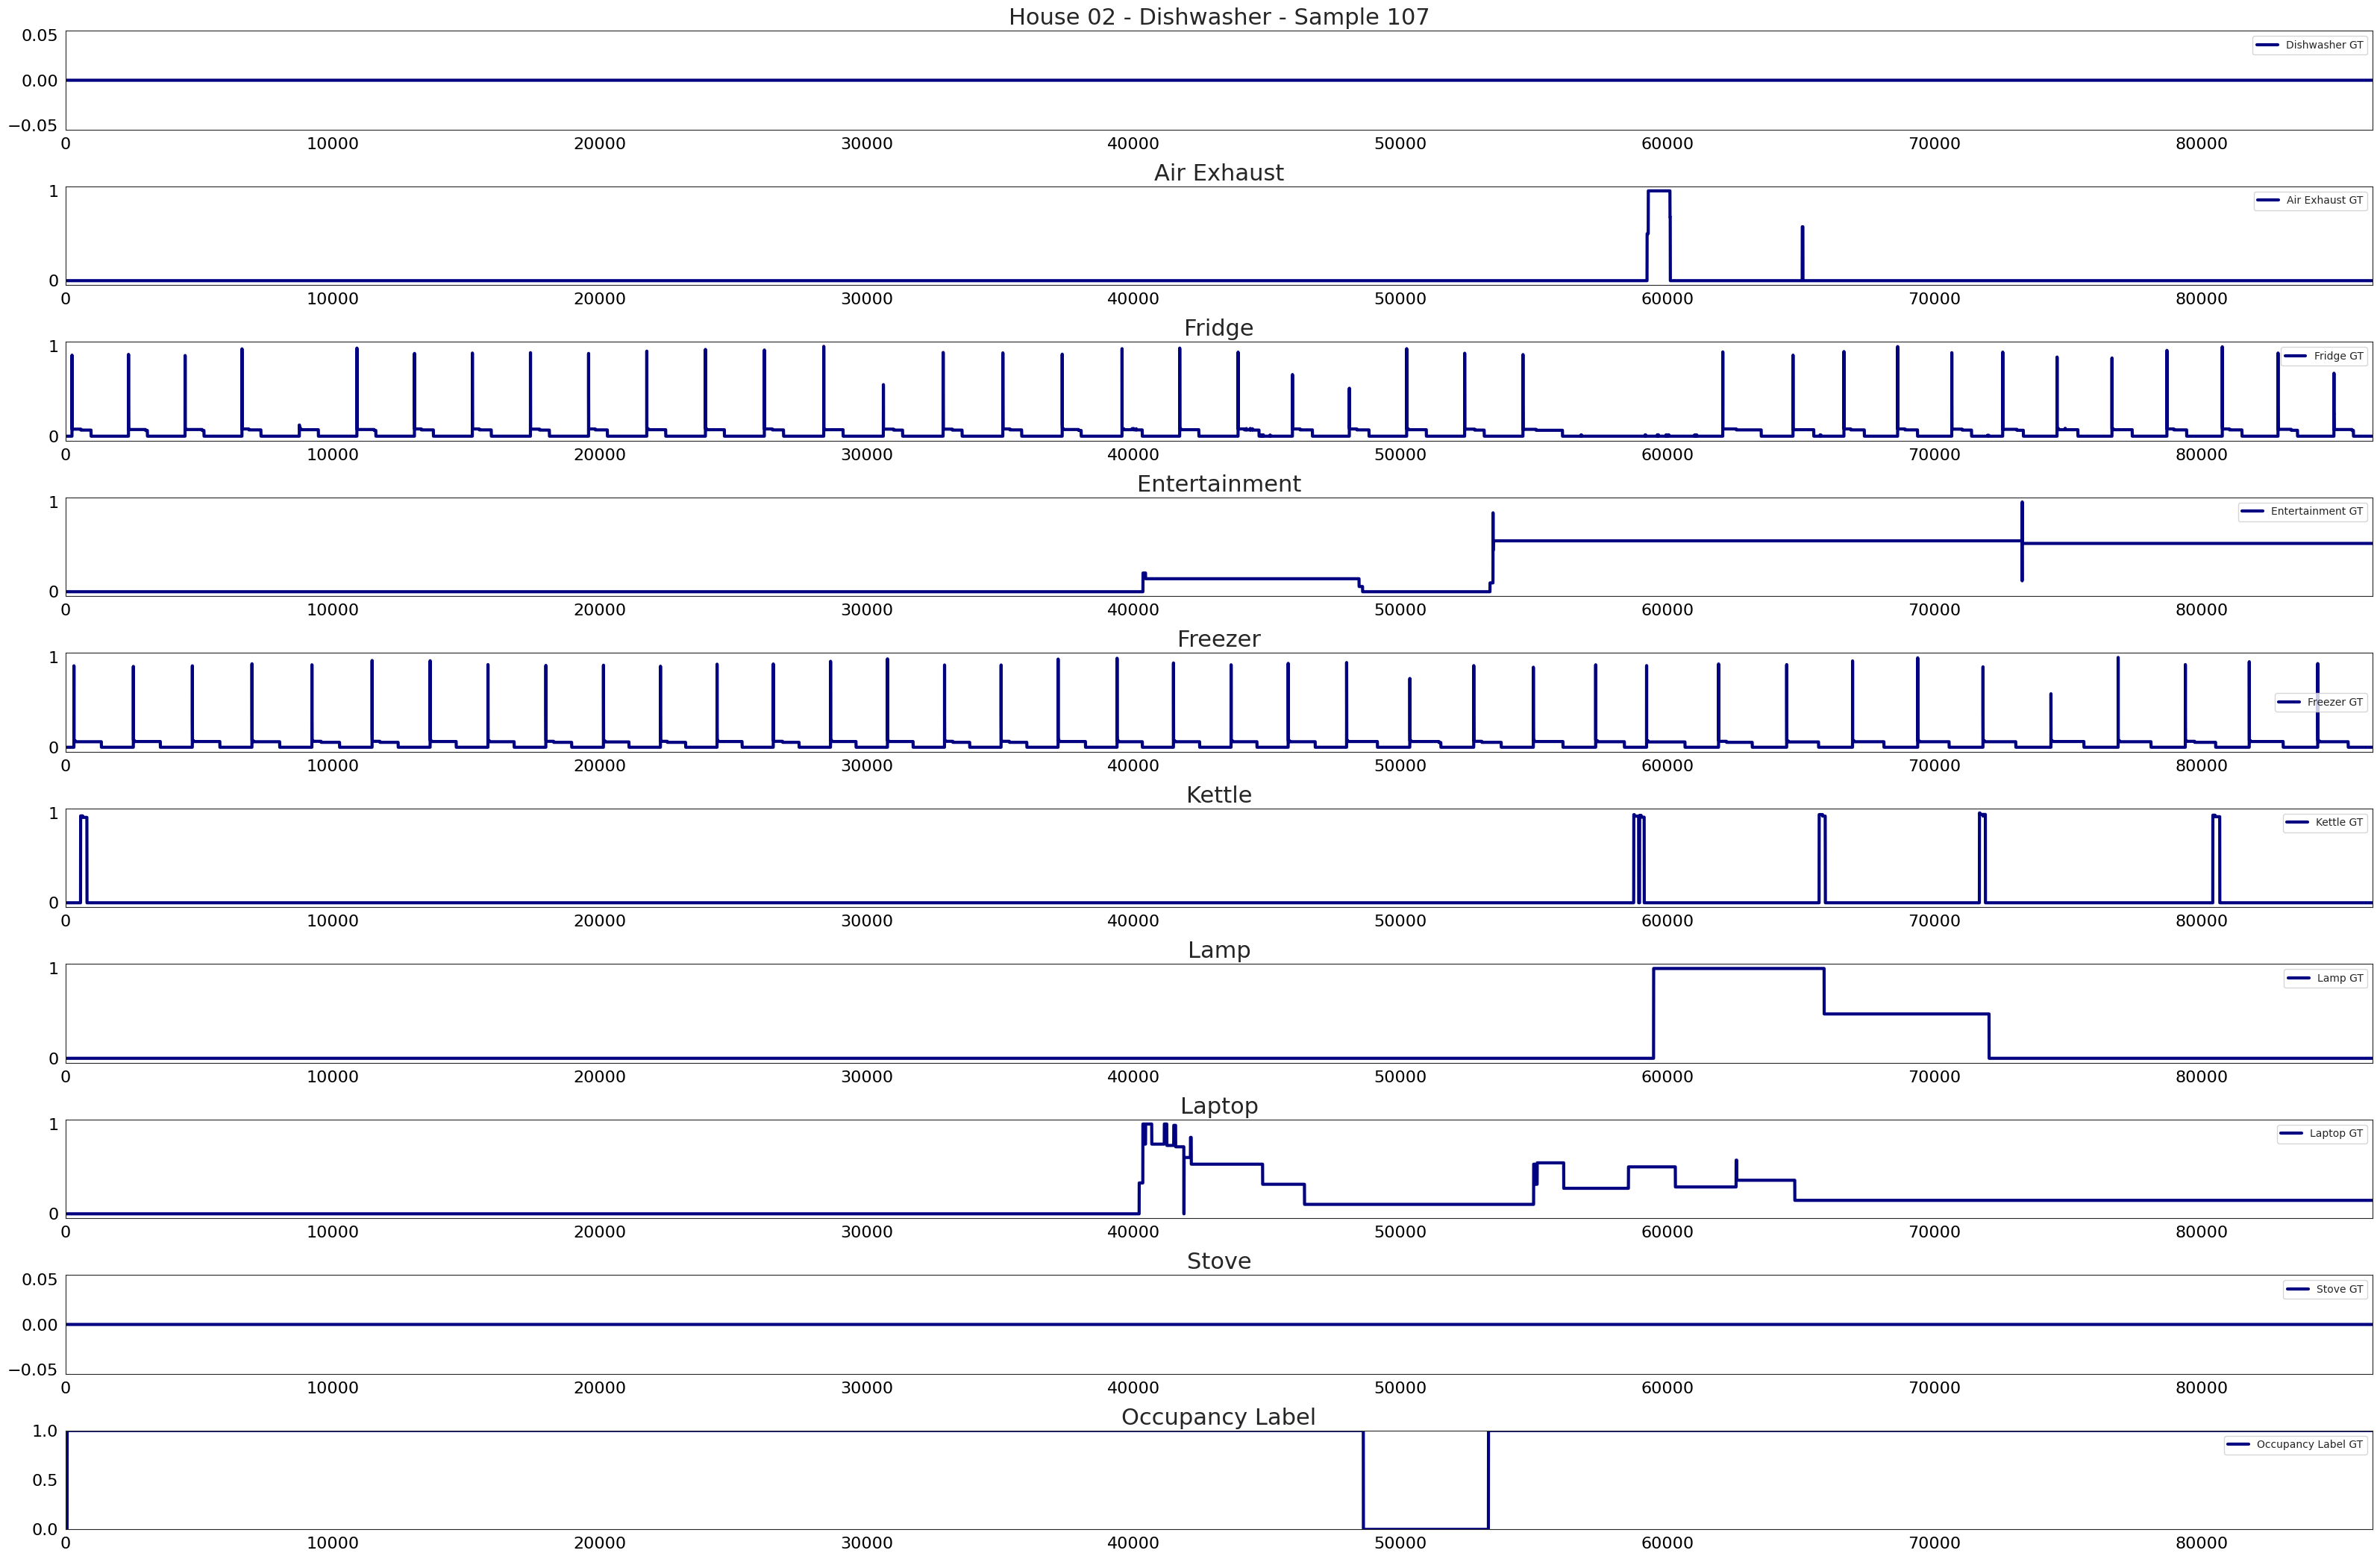

In [5]:
segment_length = 86400
i = random.randint(0, X_Data_shape[0])
'''Dishwasher'''
plt.figure(figsize=(32,21))
plt.subplot(10,1,1)
plt.plot(X_Data[i,:,0], linewidth=3, label='Dishwasher GT', color='navy')
plt.title(f"House 02 - Dishwasher - Sample {i}", fontdict={'fontsize': 22})
plt.xlim((0,segment_length))
# plt.ylim((0,1))
plt.tick_params(labelsize=16, colors='k')
plt.legend()
'''Air Exhaust'''
plt.subplot(10,1,2)
plt.plot(X_Data[i,:,1], linewidth=3, label='Air Exhaust GT', color='navy')
plt.title(f"Air Exhaust", fontdict={'fontsize': 22})
plt.xlim((0,segment_length))
# plt.ylim((0,1))
plt.tick_params(labelsize=16, colors='k')
plt.legend()
'''Fridge'''
plt.subplot(10,1,3)
plt.plot(X_Data[i,:,2], linewidth=3, label='Fridge GT', color='navy')
plt.title(f"Fridge", fontdict={'fontsize': 22})
plt.xlim((0,segment_length))
# plt.ylim((0,1))
plt.tick_params(labelsize=16, colors='k')
plt.legend()
plt.tight_layout()
'''Entertainment'''
plt.subplot(10,1,4)
plt.plot(X_Data[i,:,3], linewidth=3, label='Entertainment GT', color='navy')
plt.title(f"Entertainment", fontdict={'fontsize': 22})
plt.xlim((0,segment_length))
# plt.ylim((0,1))
plt.tick_params(labelsize=16, colors='k')
plt.legend()
'''Freezer'''
plt.subplot(10,1,5)
plt.plot(X_Data[i,:,4], linewidth=3, label='Freezer GT', color='navy')
plt.title(f"Freezer", fontdict={'fontsize': 22})
plt.xlim((0,segment_length))
# plt.ylim((0,1))
plt.tick_params(labelsize=16, colors='k')
plt.legend()
plt.subplot(10,1,6)
'''Kettle'''
plt.plot(X_Data[i,:,5], linewidth=3, label='Kettle GT', color='navy')
plt.title(f"Kettle", fontdict={'fontsize': 22})
plt.xlim((0,segment_length))
# plt.ylim((0,1))
plt.tick_params(labelsize=16, colors='k')
plt.legend()
plt.tight_layout()
'''Lamp'''
plt.subplot(10,1,7)
plt.plot(X_Data[i,:,6], linewidth=3, label='Lamp GT', color='navy')
plt.title(f"Lamp", fontdict={'fontsize': 22})
plt.xlim((0,segment_length))
# plt.ylim((0,1))
plt.tick_params(labelsize=16, colors='k')
plt.legend()
'''Laptop'''
plt.subplot(10,1,8)
plt.plot(X_Data[i,:,7], linewidth=3, label='Laptop GT', color='navy')
plt.title(f"Laptop", fontdict={'fontsize': 22})
plt.xlim((0,segment_length))
# plt.ylim((0,1))
plt.tick_params(labelsize=16, colors='k')
plt.legend()
'''Stove'''
plt.subplot(10,1,9)
plt.plot(X_Data[i,:,8], linewidth=3, label='Stove GT', color='navy')
plt.title(f"Stove", fontdict={'fontsize': 22})
plt.xlim((0,segment_length))
# plt.ylim((0,1))
plt.tick_params(labelsize=16, colors='k')
plt.legend()
plt.tight_layout()
'''Occupancy Label'''
plt.subplot(10,1,10)
plt.plot(Y_Data[i,:,0], linewidth=3, label='Occupancy Label GT', color='navy')
plt.title(f"Occupancy Label", fontdict={'fontsize': 22})
plt.xlim((0,segment_length))
plt.ylim((0,1))
plt.tick_params(labelsize=16, colors='k')
plt.legend()
plt.tight_layout()

Data Pruning - Select channels with an acceptable number of datapoints (optional, for only multichannel)

In [6]:
thresh = 0.0001
X_Data_Pruned = np.zeros((sample_num,segment_length,num_channels))
device_list = ['Dishwasher','Air_Exhaust','Fridge','Entertainment','Freezer','Kettle','Lamp','Laptop','Stove']
counter = 0
for i in range(0,num_channels):
    data_current_channel = X_Data[:,:,i]
    data_current_channel_corr, _ = stats.pearsonr(data_current_channel.ravel(), Y_Data.ravel())
    # data_current_channel_var = np.var(data_current_channel.ravel())
    if (data_current_channel_corr < thresh) or (i == 2) or (i == 4):
        print(device_list[i])
        print(data_current_channel_corr)
        continue
    else:
        X_Data_Pruned[:,:,counter] = data_current_channel
        counter = counter + 1
X_Data_Pruned = X_Data_Pruned[:,:,0:counter]
X_Data_Shape = X_Data_Pruned.shape
num_channels = X_Data_Shape[2]
print(X_Data_Pruned.shape)
print(Y_Data.shape)

Fridge
0.03294660620225685
Freezer
0.004562087404766782
(128, 86400, 7)
(128, 86400, 1)


Transform Data

In [7]:
X_Data_Shape = X_Data_Pruned.shape
sample_num = X_Data_Shape[0]
segment_length = X_Data_Shape[1]
num_channels = X_Data_Shape[2]
X_Data_New = np.zeros((sample_num,segment_length,num_channels))
# Step 1: Range Normalize Data based on [0 1] threshold
counter = 0
threshold1 = 0
for i in range(0,sample_num):
    X_Data_Temp = X_Data_Pruned[i,:,:]
    for ii in range(0,num_channels):
        X_Data_Temp_Ch = X_Data_Temp[:,ii]
        for iii in range(0,segment_length):
            X_Data_Temp_Ch_Point = X_Data_Temp_Ch[iii]
            if X_Data_Temp_Ch_Point > threshold1:
                X_Data_Temp_Ch_Point = 1
            X_Data_New[counter,iii,ii] = X_Data_Temp_Ch_Point
    counter = counter + 1
X_Data_New = np.int_(X_Data_New[0:counter,:,:])
print(X_Data_New.shape)
print(Y_Data.shape)
print(np.unique(X_Data_New))

(128, 86400, 7)
(128, 86400, 1)
[0 1]


In [8]:
# Step 2: Merge short pulses into longer one based on threshold duration
X_Data_Shape = X_Data_New.shape
sample_num = X_Data_Shape[0]
segment_length = X_Data_Shape[1]
num_channels = X_Data_Shape[2]
counter = 0
threshold2 = 3600
for i in range(0,sample_num):
    X_Data_Temp = X_Data_New[i,:,:]
    for ii in range(0,num_channels):
        X_Data_Temp_Ch = X_Data_Temp[:,ii]
        if np.var(X_Data_Temp_Ch) > 0:
            transition_points = []
            for iii in range(1,segment_length):
                X_Data_Temp_Ch_Previous_Point = X_Data_Temp_Ch[iii-1]
                X_Data_Temp_Ch_Current_Point = X_Data_Temp_Ch[iii]
                if X_Data_Temp_Ch_Previous_Point != X_Data_Temp_Ch_Current_Point:
                    transition_points.append(iii)
            # print(transition_points)
            for iii in range(1,len(transition_points)):
                if ((transition_points[iii-1]-300) >= 0) and ((transition_points[iii-1]+300) < segment_length):
                    X_Data_Temp_Ch[transition_points[iii-1]-300:transition_points[iii-1]+300] = 1
                elif ((transition_points[iii-1]-300) < 0) and ((transition_points[iii-1]+300) < segment_length):
                    X_Data_Temp_Ch[0:transition_points[iii-1]+300] = 1
                elif ((transition_points[iii-1]-300) >= 0) and ((transition_points[iii-1]+300) >= segment_length):
                    X_Data_Temp_Ch[transition_points[iii-1]-300:segment_length] = 1
                transition_interval = transition_points[iii] - transition_points[iii-1]
                if transition_interval <= threshold2:
                    X_Data_Temp_Ch[transition_points[iii-1]:transition_points[iii]] = 1
        X_Data_New[counter,:,ii] = X_Data_Temp_Ch
    counter = counter + 1
X_Data_New = X_Data_New[0:counter,:,:]
print(X_Data_New.shape)
print(Y_Data.shape)

(128, 86400, 7)
(128, 86400, 1)


In [9]:
# Step 2: Merge short pulses into longer one based on threshold duration
X_Data_Shape = X_Data_New.shape
sample_num = X_Data_Shape[0]
segment_length = X_Data_Shape[1]
num_channels = X_Data_Shape[2]
counter = 0
threshold2 = 3600
for i in range(0,sample_num):
    X_Data_Temp = X_Data_New[i,:,:]
    for ii in range(0,num_channels):
        X_Data_Temp_Ch = X_Data_Temp[:,ii]
        if np.var(X_Data_Temp_Ch) > 0:
            transition_points = []
            for iii in range(1,segment_length):
                X_Data_Temp_Ch_Previous_Point = X_Data_Temp_Ch[iii-1]
                X_Data_Temp_Ch_Current_Point = X_Data_Temp_Ch[iii]
                if X_Data_Temp_Ch_Previous_Point != X_Data_Temp_Ch_Current_Point:
                    transition_points.append(iii)
            # print(transition_points)
            for iii in range(1,len(transition_points)):
                transition_interval = transition_points[iii] - transition_points[iii-1]
                if transition_interval <= threshold2:
                    X_Data_Temp_Ch[transition_points[iii-1]:transition_points[iii]] = 1
        X_Data_New[counter,:,ii] = X_Data_Temp_Ch
    counter = counter + 1
X_Data_New = X_Data_New[0:counter,:,:]
print(X_Data_New.shape)
print(Y_Data.shape)

(128, 86400, 7)
(128, 86400, 1)


Plot again

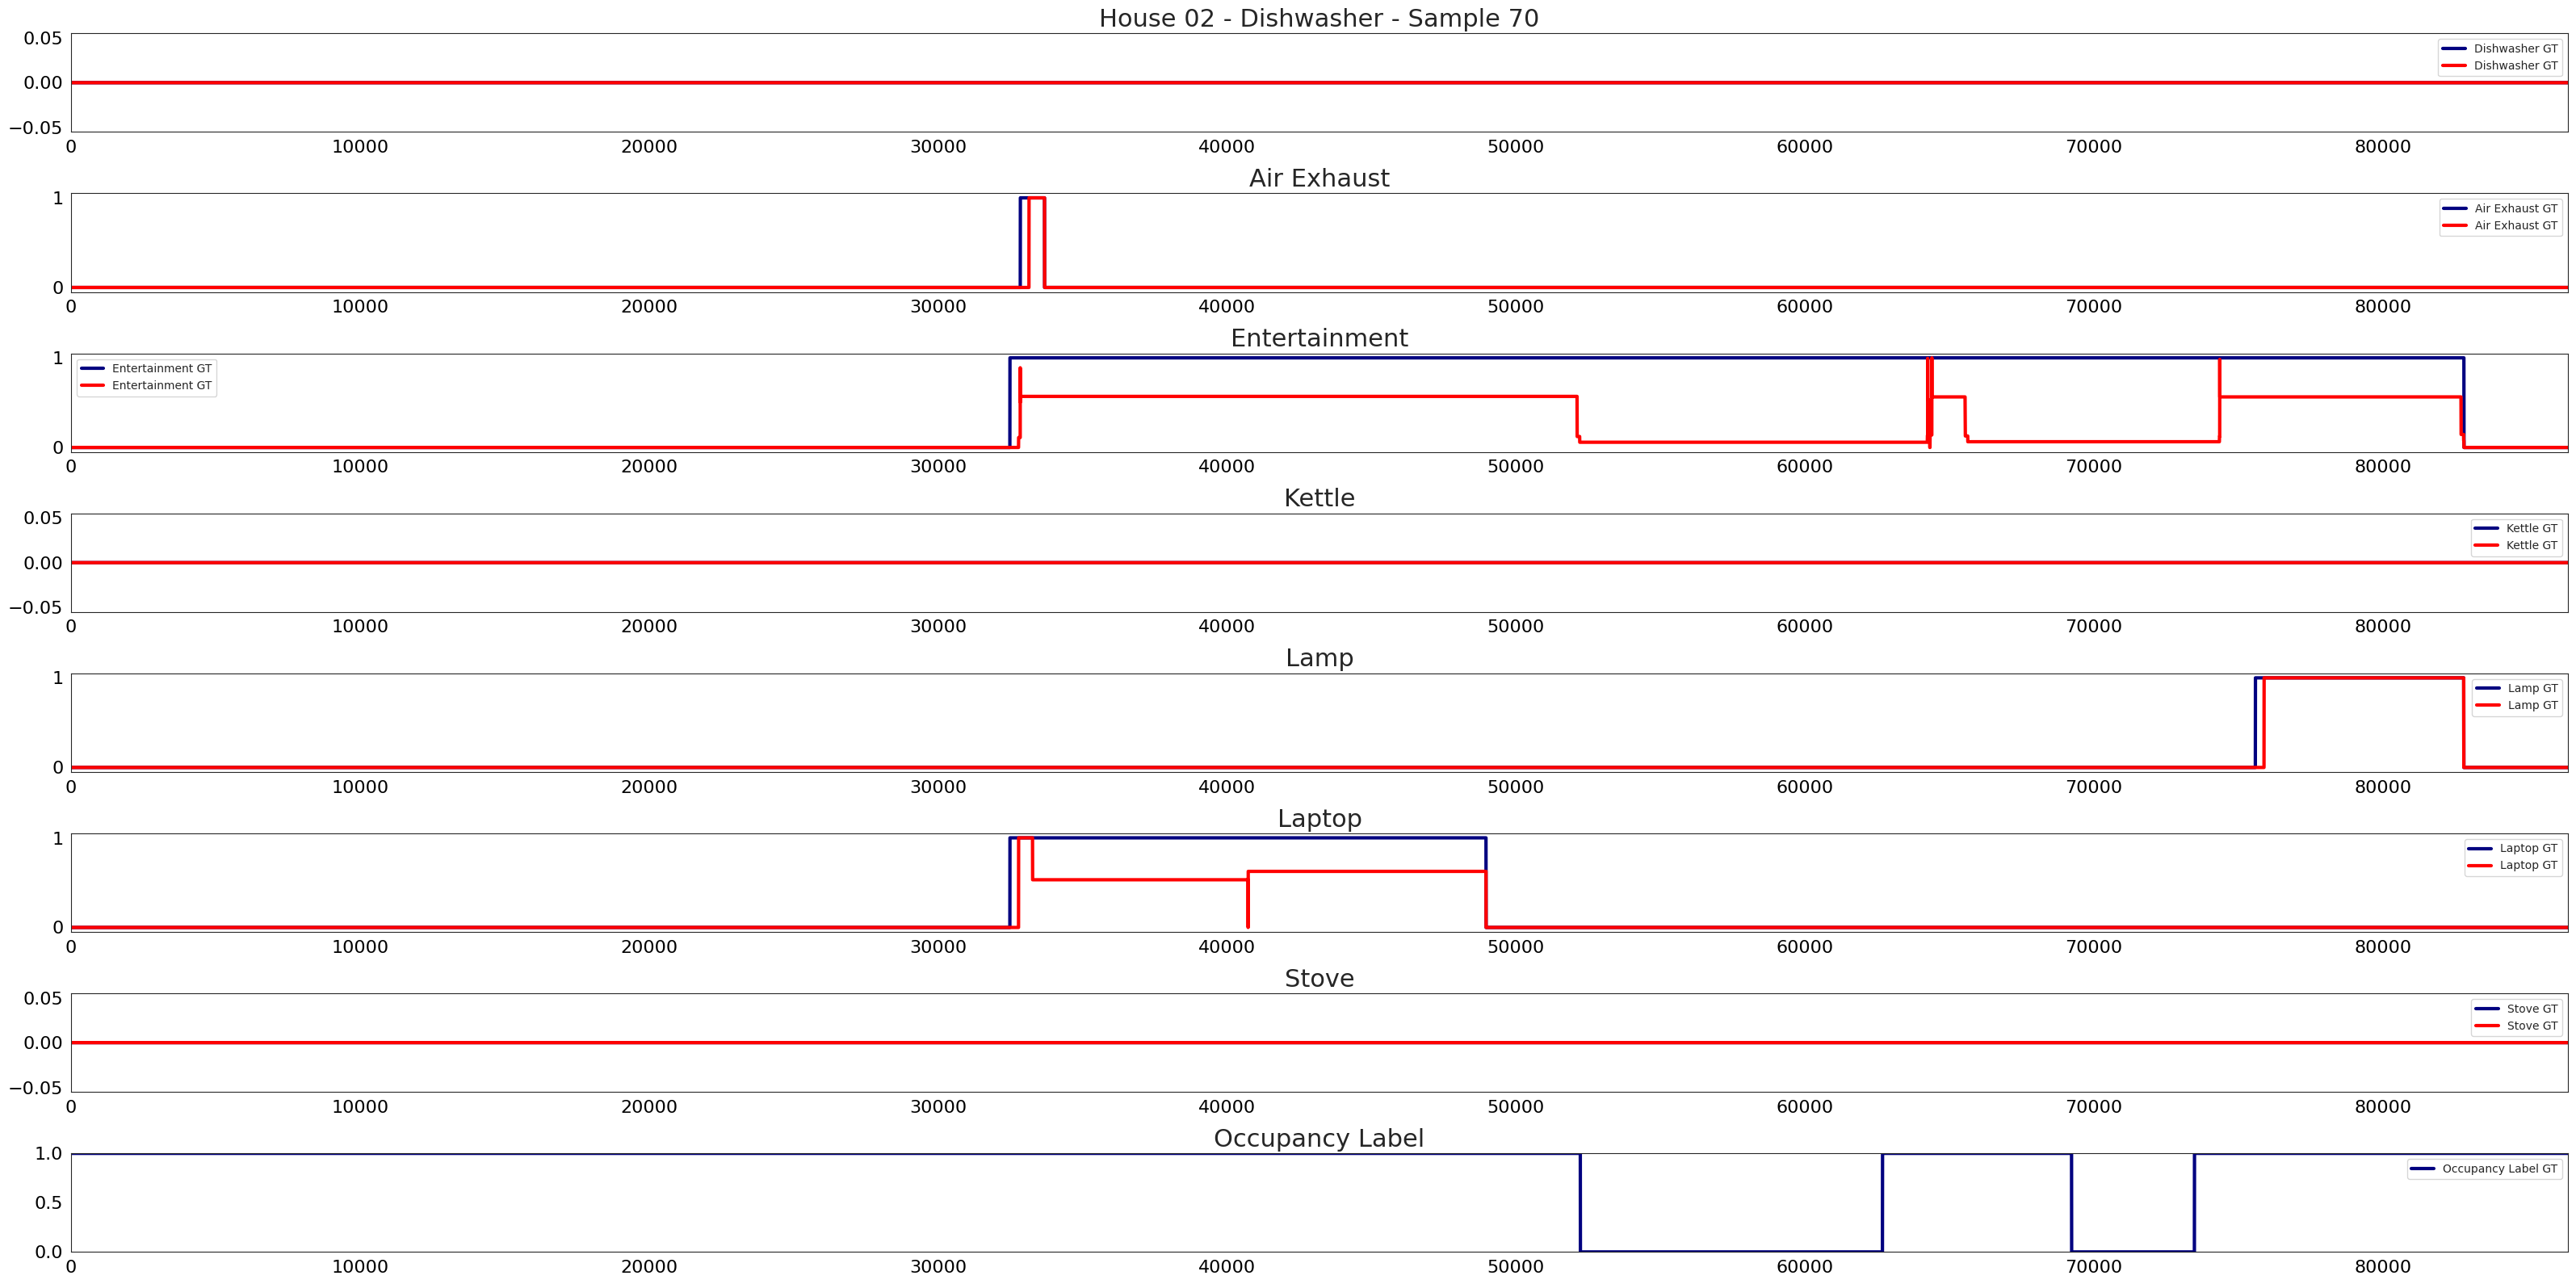

In [10]:
segment_length = 86400
i = random.randint(0, X_Data_shape[0])
# i = 10
'''Dishwasher'''
plt.figure(figsize=(32,16))
plt.subplot(8,1,1)
plt.plot(X_Data_New[i,:,0], linewidth=3, label='Dishwasher GT', color='navy')
plt.plot(X_Data[i,:,0], linewidth=3, label='Dishwasher GT', color='red')
plt.title(f"House 02 - Dishwasher - Sample {i}", fontdict={'fontsize': 22})
plt.xlim((0,segment_length))
# plt.ylim((0,1))
plt.tick_params(labelsize=16, colors='k')
plt.legend()
'''Air Exhaust'''
plt.subplot(8,1,2)
plt.plot(X_Data_New[i,:,1], linewidth=3, label='Air Exhaust GT', color='navy')
plt.plot(X_Data[i,:,1], linewidth=3, label='Air Exhaust GT', color='red')
plt.title(f"Air Exhaust", fontdict={'fontsize': 22})
plt.xlim((0,segment_length))
# plt.ylim((0,1))
plt.tick_params(labelsize=16, colors='k')
plt.legend()
'''Entertainment'''
plt.subplot(8,1,3)
plt.plot(X_Data_New[i,:,2], linewidth=3, label='Entertainment GT', color='navy')
plt.plot(X_Data[i,:,3], linewidth=3, label='Entertainment GT', color='red')
plt.title(f"Entertainment", fontdict={'fontsize': 22})
plt.xlim((0,segment_length))
# plt.ylim((0,1))
plt.tick_params(labelsize=16, colors='k')
plt.legend()
'''Kettle'''
plt.subplot(8,1,4)
plt.plot(X_Data_New[i,:,3], linewidth=3, label='Kettle GT', color='navy')
plt.plot(X_Data[i,:,5], linewidth=3, label='Kettle GT', color='red')
plt.title(f"Kettle", fontdict={'fontsize': 22})
plt.xlim((0,segment_length))
# plt.ylim((0,1))
plt.tick_params(labelsize=16, colors='k')
plt.legend()
plt.tight_layout()
'''Lamp'''
plt.subplot(8,1,5)
plt.plot(X_Data_New[i,:,4], linewidth=3, label='Lamp GT', color='navy')
plt.plot(X_Data[i,:,6], linewidth=3, label='Lamp GT', color='red')
plt.title(f"Lamp", fontdict={'fontsize': 22})
plt.xlim((0,segment_length))
# plt.ylim((0,1))
plt.tick_params(labelsize=16, colors='k')
plt.legend()
'''Laptop'''
plt.subplot(8,1,6)
plt.plot(X_Data_New[i,:,5], linewidth=3, label='Laptop GT', color='navy')
plt.plot(X_Data[i,:,7], linewidth=3, label='Laptop GT', color='red')
plt.title(f"Laptop", fontdict={'fontsize': 22})
plt.xlim((0,segment_length))
# plt.ylim((0,1))
plt.tick_params(labelsize=16, colors='k')
plt.legend()
'''Stove'''
plt.subplot(8,1,7)
plt.plot(X_Data_New[i,:,6], linewidth=3, label='Stove GT', color='navy')
plt.plot(X_Data[i,:,8], linewidth=3, label='Stove GT', color='red')
plt.title(f"Stove", fontdict={'fontsize': 22})
plt.xlim((0,segment_length))
# plt.ylim((0,1))
plt.tick_params(labelsize=16, colors='k')
plt.legend()
plt.tight_layout()
'''Occupancy Label'''
plt.subplot(8,1,8)
plt.plot(Y_Data[i,:,0], linewidth=3, label='Occupancy Label GT', color='navy')
plt.title(f"Occupancy Label", fontdict={'fontsize': 22})
plt.xlim((0,segment_length))
plt.ylim((0,1))
plt.tick_params(labelsize=16, colors='k')
plt.legend()
plt.tight_layout()

Combine Channels

In [11]:
X_Data_Shape = X_Data_New.shape
Y_Data_Shape = Y_Data.shape
sample_num = X_Data_Shape[0]
segment_length = X_Data_Shape[1]
num_channels = X_Data_Shape[2]
X_Data_AGG = np.zeros((sample_num,segment_length,1))
counter = 0
for i in range(0,sample_num):
    X_Data_Temp = X_Data_New[i,:,:]
    X_Data_Temp = np.sum(X_Data_Temp, axis=1)
    X_Data_Temp[X_Data_Temp > 0] = 1
    X_Data_AGG[counter,:,0] = X_Data_Temp
    counter = counter + 1
X_Data_AGG = np.int_(X_Data_AGG[0:counter,:,:])
print(X_Data_AGG.shape)
print(Y_Data.shape)
print(np.unique(X_Data_AGG))
print(np.unique(Y_Data))

(128, 86400, 1)
(128, 86400, 1)
[0 1]
[0 1]


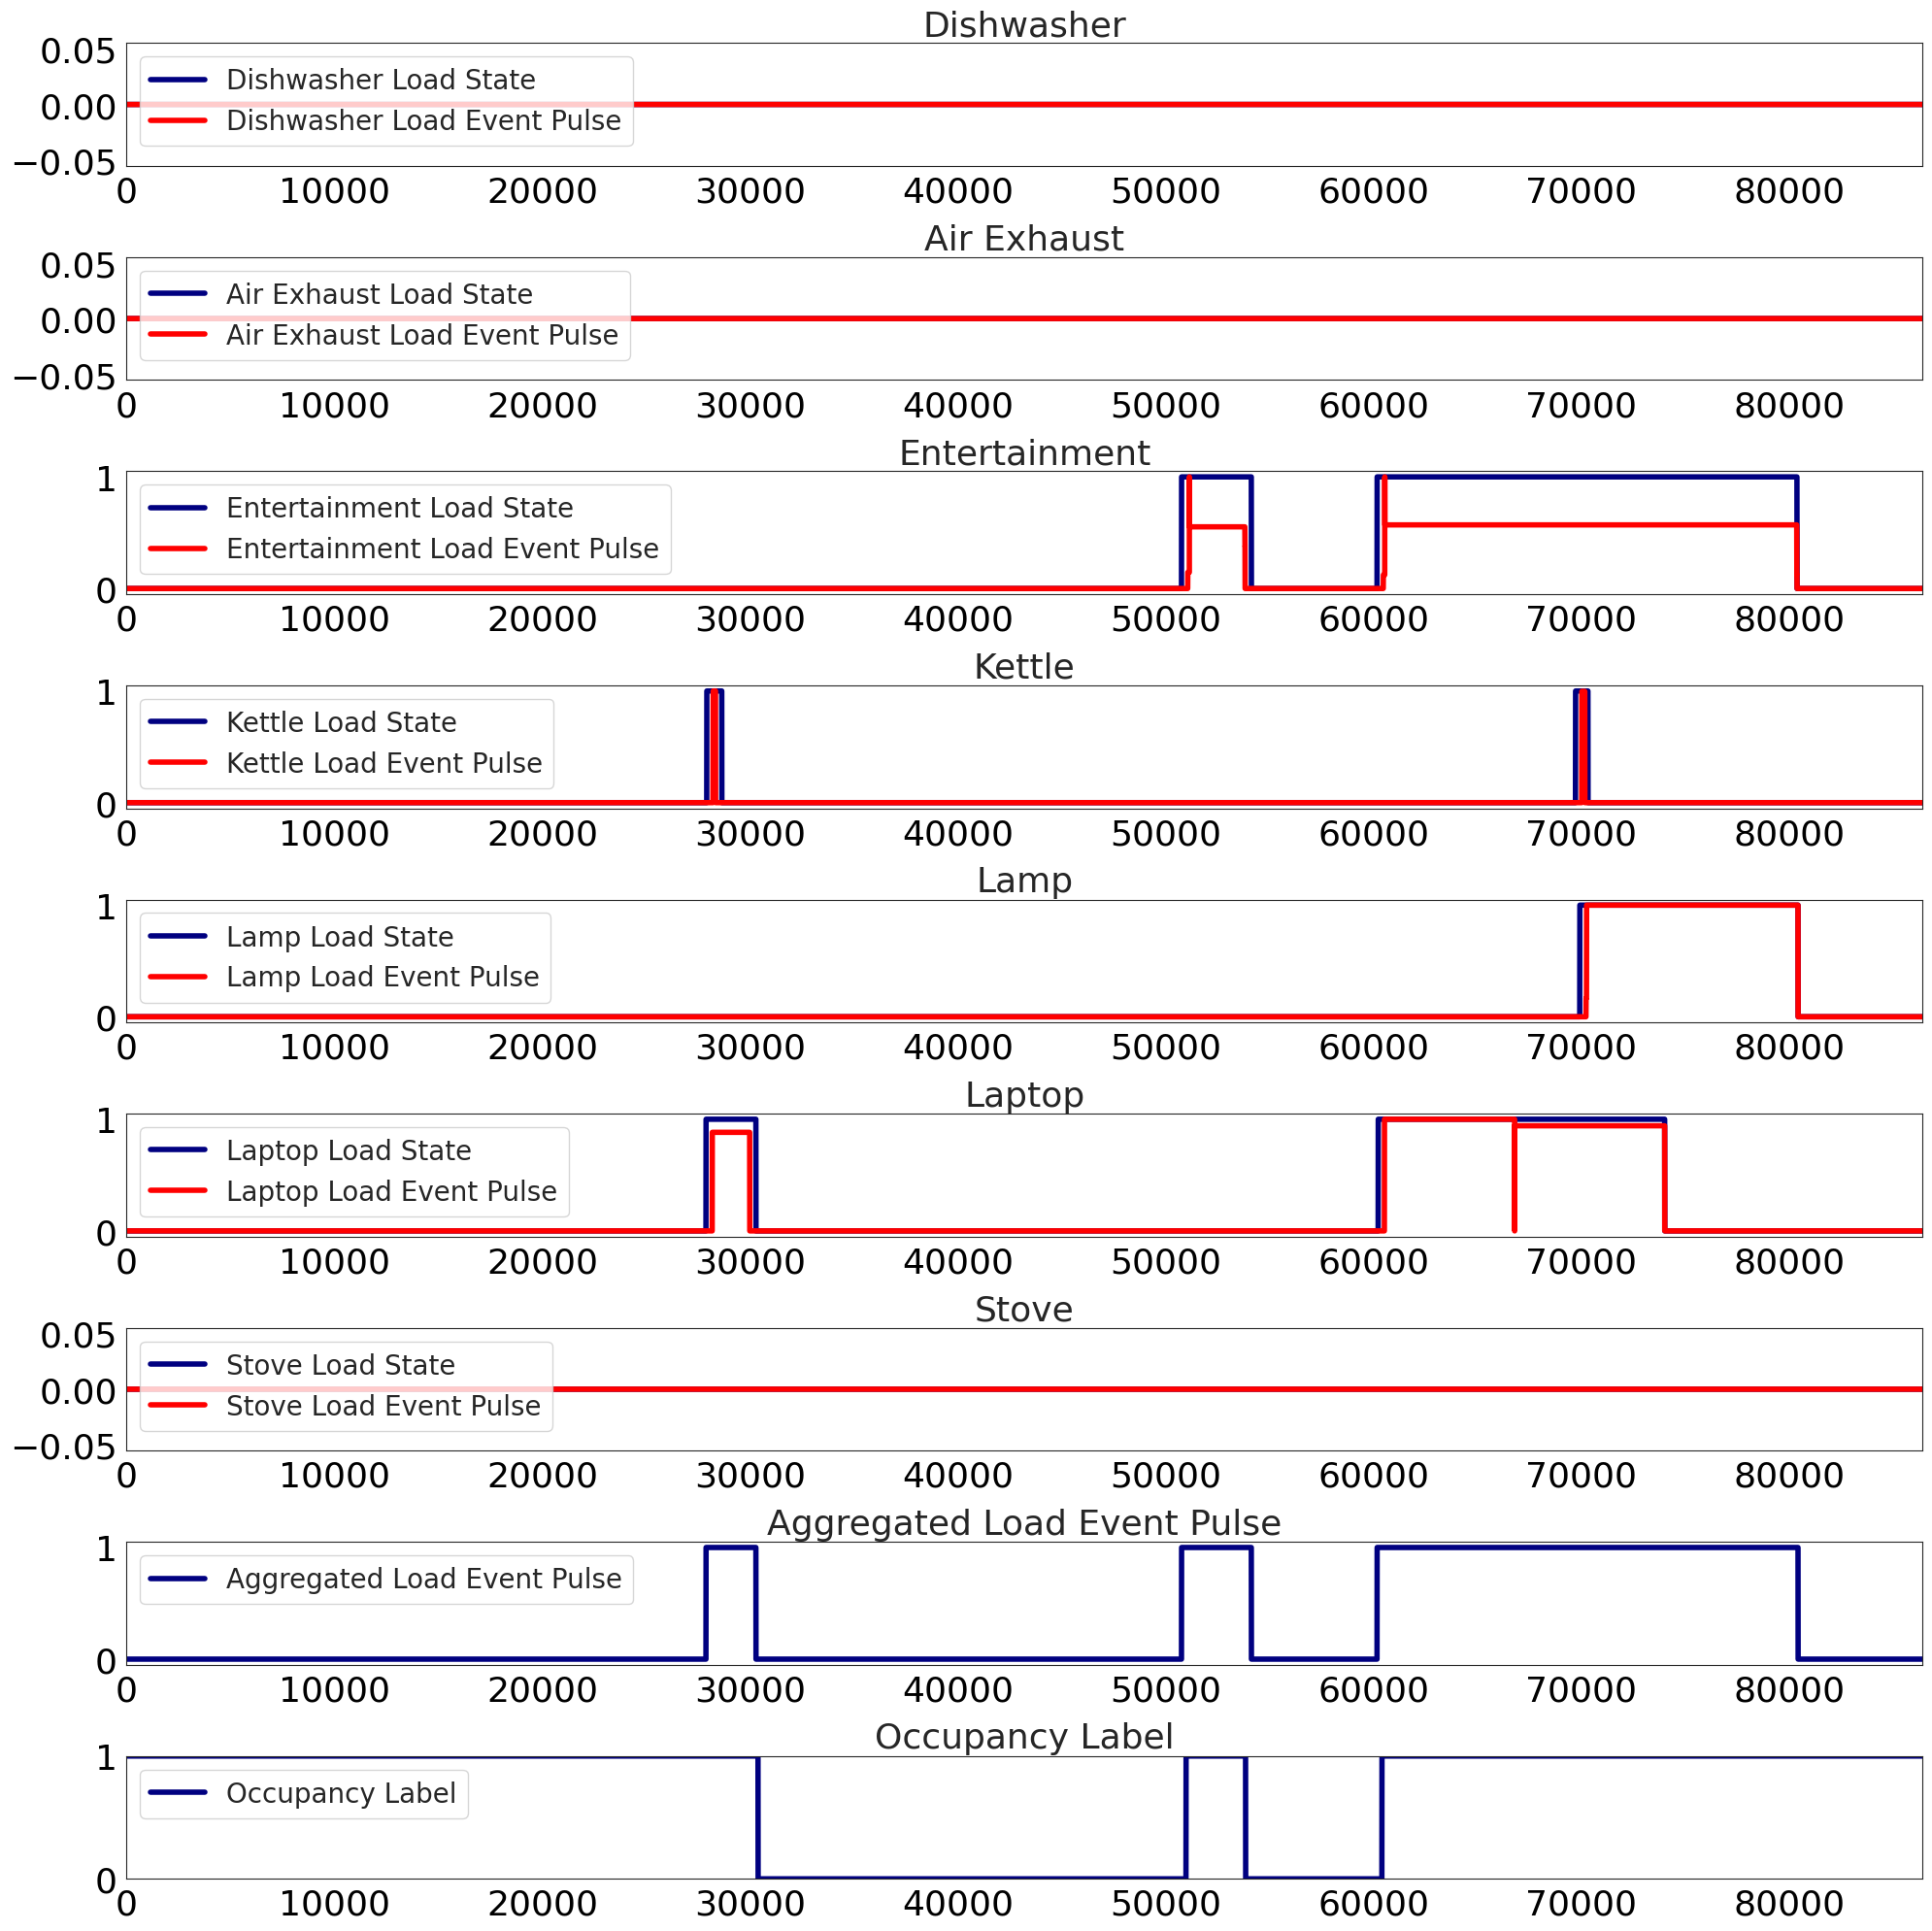

In [19]:
segment_length = 86400
i = random.randint(0, X_Data_shape[0])
# i = 30
'''Dishwasher'''
plt.figure(figsize=(20,20))
plt.subplot(9,1,1)
plt.plot(X_Data_New[i,:,0], linewidth=4, label='Dishwasher Load State', color='navy')
plt.plot(X_Data[i,:,0], linewidth=4, label='Dishwasher Load Event Pulse', color='red')
plt.title(f"Dishwasher", fontdict={'fontsize': 26, 'fontweight': 5})
plt.xlim((0,segment_length))
# plt.ylim((0,1))
plt.tick_params(labelsize=26, colors='k')
plt.legend(fontsize=20, loc='upper left')
'''Air Exhaust'''
plt.subplot(9,1,2)
plt.plot(X_Data_New[i,:,1], linewidth=4, label='Air Exhaust Load State', color='navy')
plt.plot(X_Data[i,:,1], linewidth=4, label='Air Exhaust Load Event Pulse', color='red')
plt.title(f"Air Exhaust", fontdict={'fontsize': 26})
plt.xlim((0,segment_length))
# plt.ylim((0,1))
plt.tick_params(labelsize=26, colors='k')
plt.legend(fontsize=20, loc='upper left')
'''Entertainment'''
plt.subplot(9,1,3)
plt.plot(X_Data_New[i,:,2], linewidth=4, label='Entertainment Load State', color='navy')
plt.plot(X_Data[i,:,3], linewidth=4, label='Entertainment Load Event Pulse', color='red')
plt.title(f"Entertainment", fontdict={'fontsize': 26})
plt.xlim((0,segment_length))
# plt.ylim((0,1))
plt.tick_params(labelsize=26, colors='k')
plt.legend(fontsize=20, loc='upper left')
'''Kettle'''
plt.subplot(9,1,4)
plt.plot(X_Data_New[i,:,3], linewidth=4, label='Kettle Load State', color='navy')
plt.plot(X_Data[i,:,5], linewidth=4, label='Kettle Load Event Pulse', color='red')
plt.title(f"Kettle", fontdict={'fontsize': 26})
plt.xlim((0,segment_length))
# plt.ylim((0,1))
plt.tick_params(labelsize=26, colors='k')
plt.legend(fontsize=20, loc='upper left')
plt.tight_layout()
'''Lamp'''
plt.subplot(9,1,5)
plt.plot(X_Data_New[i,:,4], linewidth=4, label='Lamp Load State', color='navy')
plt.plot(X_Data[i,:,6], linewidth=4, label='Lamp Load Event Pulse', color='red')
plt.title(f"Lamp", fontdict={'fontsize': 26})
plt.xlim((0,segment_length))
# plt.ylim((0,1))
plt.tick_params(labelsize=26, colors='k')
plt.legend(fontsize=20, loc='upper left')
'''Laptop'''
plt.subplot(9,1,6)
plt.plot(X_Data_New[i,:,5], linewidth=4, label='Laptop Load State', color='navy')
plt.plot(X_Data[i,:,7], linewidth=4, label='Laptop Load Event Pulse', color='red')
plt.title(f"Laptop", fontdict={'fontsize': 26})
plt.xlim((0,segment_length))
# plt.ylim((0,1))
plt.tick_params(labelsize=26, colors='k')
plt.legend(fontsize=20, loc='upper left')
'''Stove'''
plt.subplot(9,1,7)
plt.plot(X_Data_New[i,:,6], linewidth=4, label='Stove Load State', color='navy')
plt.plot(X_Data[i,:,8], linewidth=4, label='Stove Load Event Pulse', color='red')
plt.title(f"Stove", fontdict={'fontsize': 26})
plt.xlim((0,segment_length))
# plt.ylim((0,1))
plt.tick_params(labelsize=26, colors='k')
plt.legend(fontsize=20, loc='upper left')
plt.tight_layout()
'''Aggregated Data'''
plt.subplot(9,1,8)
plt.plot(X_Data_AGG[i,:,0], linewidth=4, label='Aggregated Load Event Pulse', color='navy')
plt.title(f"Aggregated Load Event Pulse", fontdict={'fontsize': 26})
plt.xlim((0,segment_length))
# plt.ylim((0,1))
plt.tick_params(labelsize=26, colors='k')
plt.legend(fontsize=20, loc='upper left')
plt.tight_layout()
'''Occupancy Label'''
plt.subplot(9,1,9)
plt.plot(Y_Data[i,:,0], linewidth=4, label='Occupancy Label', color='navy')
plt.title(f"Occupancy Label", fontdict={'fontsize': 26})
plt.xlim((0,segment_length))
plt.ylim((0,1))
plt.tick_params(labelsize=26, colors='k')
plt.legend(fontsize=20, loc='upper left')
plt.tight_layout()
# Save
plt.savefig(f'Aggregated Pulse', bbox_inches='tight', dpi=600)

Plot Aggregated Ground Truth

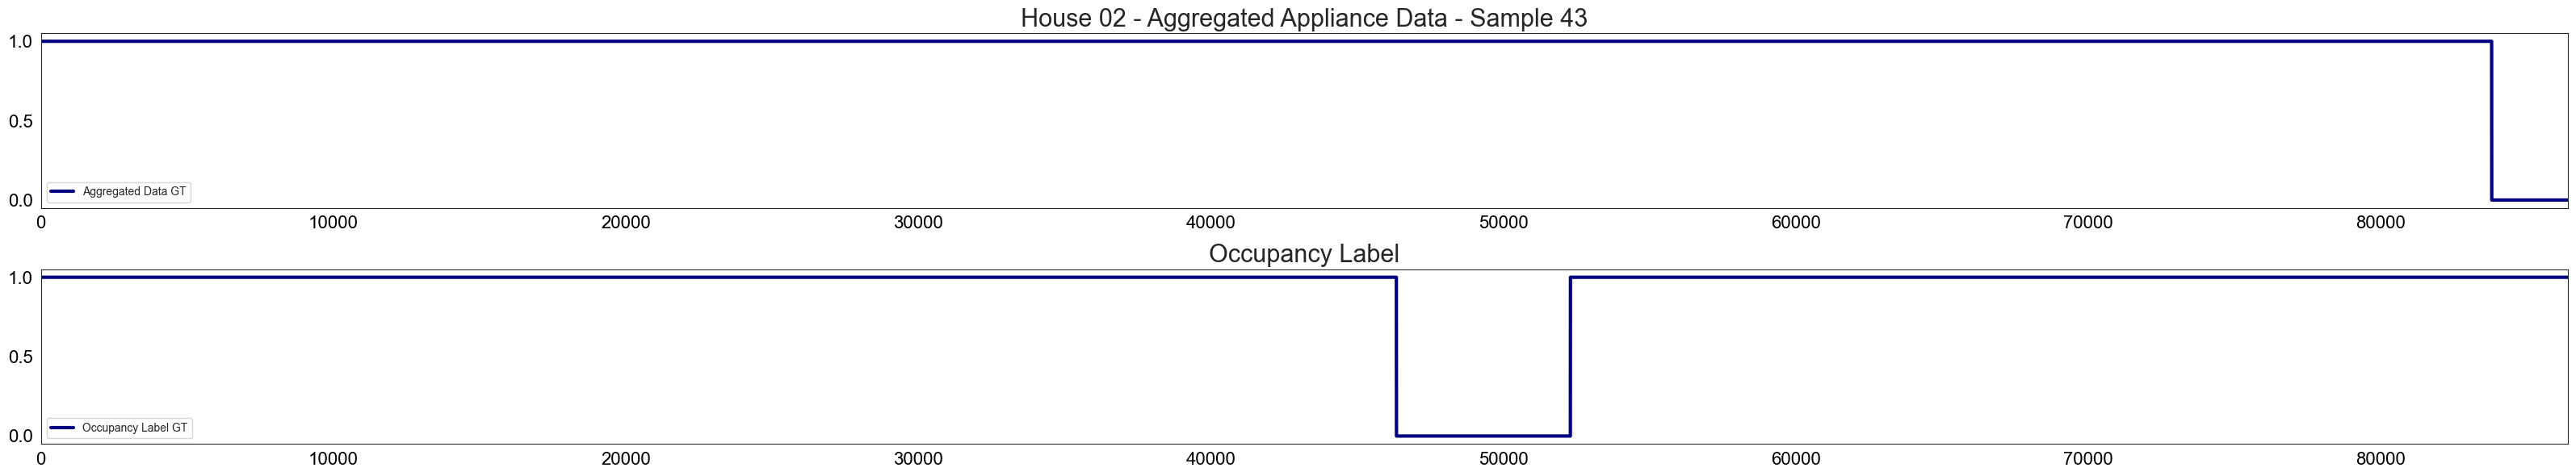

In [18]:
segment_length = 86400
i = random.randint(0, X_Data_AGG.shape[0]-1)
'''Dishwasher'''
plt.figure(figsize=(32,6))
plt.subplot(2,1,1)
plt.plot(X_Data_AGG[i,:,0], linewidth=3, label='Aggregated Data GT', color='navy')
plt.title(f"House 02 - Aggregated Appliance Data - Sample {i}", fontdict={'fontsize': 22})
plt.xlim((0,segment_length))
plt.tick_params(labelsize=16, colors='k')
plt.legend()
'''Occupancy Label'''
plt.subplot(2,1,2)
plt.plot(Y_Data[i,:,0], linewidth=3, label='Occupancy Label GT', color='navy')
plt.title(f"Occupancy Label", fontdict={'fontsize': 22})
plt.xlim((0,segment_length))
# plt.ylim((0,1))
plt.tick_params(labelsize=16, colors='k')
plt.legend()
plt.tight_layout()

Cleanse and Save House 02 data for the combined approach

In [19]:
# Curate
X_Data_Shape = X_Data_AGG.shape
Y_Data_Shape = Y_Data.shape
sample_num = X_Data_Shape[0]
segment_length = X_Data_Shape[1]
num_channels = X_Data_Shape[2]
X_Data_Curated = np.zeros((sample_num,segment_length,num_channels))
Y_Data_Curated = np.zeros((sample_num,segment_length,1))
counter = 0
for i in range(0,sample_num):
    X_Data_Temp = X_Data_AGG[i,:,:]
    Y_Data_Temp = Y_Data[i,:,:]
    Y_Data_Temp_SUM = np.sum(Y_Data_Temp)
    if (Y_Data_Temp_SUM < np.round(0.01*segment_length)) or (Y_Data_Temp_SUM > np.round(0.99*segment_length)):
        continue
    if (np.var(X_Data_Temp) > 0.0001):
        X_Data_Curated[counter,:,:] = X_Data_Temp
        Y_Data_Curated[counter,:,:] = Y_Data_Temp
        counter = counter + 1
X_Data_Curated = np.int_(X_Data_Curated[0:counter,:,:])
Y_Data_Curated = np.int_(Y_Data_Curated[0:counter,:,:])
print(X_Data_Curated.shape)
print(Y_Data_Curated.shape)
print(np.unique(X_Data_Curated))
print(np.unique(Y_Data_Curated))
# Save
data_dic = {"X_Data": X_Data_Curated,
            "Y_Data": Y_Data_Curated,
            }
savemat("Occupancy_Data_Curated_House_02_V2.mat", data_dic, format='5')

(110, 86400, 1)
(110, 86400, 1)
[0 1]
[0 1]


Create Folds - Train and Test Sets - 20% for Test - 10% for Validation

In [62]:
X_Train, X_Test, Y_Train, Y_Test = train_test_split(X_Data_AGG, Y_Data, test_size=0.2, random_state=0)
X_Val = X_Test
Y_Val = Y_Test
print(X_Train.shape)
print(Y_Train.shape)
print(X_Test.shape)
print(Y_Test.shape)
print(X_Val.shape)
print(Y_Val.shape)

(102, 86400, 1)
(102, 86400, 1)
(26, 86400, 1)
(26, 86400, 1)
(26, 86400, 1)
(26, 86400, 1)


Overlap Train Set

In [63]:
# Overlap
X_Data_Shape = X_Train.shape
Y_Data_Shape = Y_Train.shape
segment_length = X_Data_Shape[1]
num_channels = X_Data_Shape[2]
print(X_Data_Shape)
print(Y_Data_Shape)
# Reshape Array
X_Data_Reshaped = np.reshape(X_Train, (X_Data_Shape[0]*X_Data_Shape[1], num_channels))
Y_Data_Reshaped = np.reshape(Y_Train, (Y_Data_Shape[0]*Y_Data_Shape[1], 1))
X_Data_Reshaped_Shape = X_Data_Reshaped.shape
Y_Data_Reshaped_Shape = Y_Data_Reshaped.shape
print(X_Data_Reshaped_Shape)
print(Y_Data_Reshaped_Shape)
# Overlap
overlap_ratio = 0.9
offset_amount = np.int_(segment_length*(1 - overlap_ratio))
X_Data_New = np.zeros((2000,segment_length,num_channels))
Y_Data_New = np.zeros((2000,segment_length,1))
num_segments_approx = np.int_(np.ceil(X_Data_Reshaped_Shape[0]/offset_amount))
counter = 0
for i in range(0,num_segments_approx):
    if (i*offset_amount+segment_length) > X_Data_Reshaped_Shape[0]:
        continue
    X_Data_Temp = X_Data_Reshaped[i*offset_amount:i*offset_amount+segment_length,:]
    X_Data_New[counter,:,:] = X_Data_Temp
    Y_Data_Temp = Y_Data_Reshaped[i*offset_amount:i*offset_amount+segment_length,:]
    Y_Data_New[counter,:,:] = Y_Data_Temp
    counter = counter + 1
X_Train_OVRL = X_Data_New[0:counter,:,:]
Y_Train_OVRL = Y_Data_New[0:counter,:,:]
print(X_Train_OVRL.shape)
print(Y_Train_OVRL.shape)

(102, 86400, 1)
(102, 86400, 1)
(8812800, 1)
(8812800, 1)
(1011, 86400, 1)
(1011, 86400, 1)


Transform Labels for Classification

In [64]:
def transform_labels(X_Data_OVRL, Y_Data_OVRL, segment_length, num_channels):
    X_Data_New = np.zeros((20000,num_channels,segment_length))
    Y_Data_New = np.zeros((20000,1), dtype=int)
    ## Raw Dataset
    X_Data_Shape = X_Data_OVRL.shape
    Y_Data_Shape = Y_Data_OVRL.shape
    # Reshape Array
    X_Data_Reshaped = np.reshape(X_Data_OVRL, (X_Data_Shape[0]*X_Data_Shape[1], num_channels))
    Y_Data_Reshaped = np.reshape(Y_Data_OVRL, (Y_Data_Shape[0]*Y_Data_Shape[1], 1))
    X_Data_Reshaped_Shape = X_Data_Reshaped.shape
    Y_Data_Reshaped_Shape = Y_Data_Reshaped.shape
    num_segments_approx = np.int_(np.ceil(X_Data_Reshaped_Shape[0]/segment_length))
    counter = 0
    for i in range(0,num_segments_approx):
        if ((i+1)*segment_length) > X_Data_Reshaped_Shape[0]:
            continue
        X_Data_Temp = np.transpose(X_Data_Reshaped[i*segment_length:(i+1)*segment_length,:])
        X_Data_Temp_Mean = np.mean(X_Data_Temp)
        X_Data_Temp_VAR = np.var(X_Data_Temp)
        X_Data_New[counter,:,:] = X_Data_Temp
        Y_Data_Temp = Y_Data_Reshaped[i*segment_length:(i+1)*segment_length,:]
        Y_Data_Temp_Mean = np.mean(Y_Data_Temp)
        Y_Data_Temp_VAR = np.var(Y_Data_Temp)
        Y_Data_Temp_SUM = np.sum(Y_Data_Temp)
        if X_Data_Temp_VAR <= 0.0001:
            continue
        # if Y_Data_Temp_VAR <= 0.001:
            # continue
        if (Y_Data_Temp_SUM < np.round(0.1*segment_length)) or (Y_Data_Temp_SUM > np.round(0.90*segment_length)):
            continue
        # if Y_Data_Temp_SUM == segment_length:
            # continue
        if Y_Data_Temp_Mean > 0.5:
            Y_Label = 1
        else:
            Y_Label = 0
        Y_Data_New[counter,:] = Y_Label
        counter = counter + 1
    X_Data_New = X_Data_New[0:counter,:,:]
    Y_Data_New = Y_Data_New[0:counter,:]
    return X_Data_New, Y_Data_New

In [65]:
segment_length = 1200  # 20 Minutes = 1200 Data Points (1 Hz sampling rate)
X_Train_C, Y_Train_C = transform_labels(X_Train_OVRL, Y_Train_OVRL, segment_length, num_channels)
X_Test_C, Y_Test_C = transform_labels(X_Test, Y_Test, segment_length, num_channels)
X_Val_C, Y_Val_C = transform_labels(X_Test, Y_Test, segment_length, num_channels)
print(X_Train_C.shape)
print(Y_Train_C.shape)
print(X_Test_C.shape)
print(Y_Test_C.shape)
print(X_Val_C.shape)
print(Y_Val_C.shape)
labels, counts = np.unique(Y_Train_C, return_counts=True)
print(labels, counts)
labels, counts = np.unique(Y_Test_C, return_counts=True)
print(labels, counts)
labels, counts = np.unique(Y_Val_C, return_counts=True)
print(labels, counts)


(849, 1, 1200)
(849, 1)
(26, 1, 1200)
(26, 1)
(26, 1, 1200)
(26, 1)
[0 1] [379 470]
[0 1] [12 14]
[0 1] [12 14]


Balance train set (if required)

In [11]:
Y_Train_0_indices = np.where(Y_Train_C == 0)[0]
X_Train_C_0 = np.take(X_Train_C, Y_Train_0_indices, axis=0)
Y_Train_C_0 = np.take(Y_Train_C, Y_Train_0_indices, axis=0)
Y_Train_1_indices = np.where(Y_Train_C == 1)[0]
X_Train_C_1 = np.take(X_Train_C, Y_Train_1_indices, axis=0)
Y_Train_C_1 = np.take(Y_Train_C, Y_Train_1_indices, axis=0)
#
Y_Train_C_0_shape = Y_Train_C_0.shape
Y_Train_C_1_shape = Y_Train_C_1.shape
Y_Train_C_shape = Y_Train_C.shape
if Y_Train_C_1_shape[0] > Y_Train_C_0_shape[0]:
    index = np.random.choice(Y_Train_C_1_shape[0], Y_Train_C_0_shape[0], replace=False)
    X_Train_1 = X_Train_C_1[index]
    Y_Train_1 = Y_Train_C_1[index]
    X_Train = np.concatenate([X_Train_C_0, X_Train_1], axis=0)
    Y_Train = np.concatenate([Y_Train_C_0, Y_Train_1], axis=0)
elif Y_Train_C_0_shape[0] > Y_Train_C_1_shape[0]:
    index = np.random.choice(Y_Train_C_0_shape[0], Y_Train_C_1_shape[0], replace=False)
    X_Train_0 = X_Train_C_0[index]
    Y_Train_0 = Y_Train_C_0[index]
    X_Train = np.concatenate([X_Train_C_1, X_Train_0], axis=0)
    Y_Train = np.concatenate([Y_Train_C_1, Y_Train_0], axis=0)
#
X_Train_C = X_Train
Y_Train_C = Y_Train
print(X_Train_C.shape)
print(Y_Train_C.shape)

(974, 8, 1200)
(974, 1)


In [66]:
train_data_dic = {"X_Train": X_Train_C,
                  "Y_Train": Y_Train_C,
                  "X_Test": X_Test_C,
                  "Y_Test": Y_Test_C,
                  "X_Val": X_Test_C,
                  "Y_Val": Y_Test_C,
                  }
savemat("Data/Data_Fold_1.mat", train_data_dic, format='5')

Garbage Collector

In [ ]:
import gc #Garbage Collector
fl_Data = None
X_Test = None
X_Train = None
X_Val = None
Y_Test = None
Y_Train = None
Y_Val = None
gc.collect()

0

# MAIN

## Configurations

In [67]:
# CREATE OBJECT
config_file = configparser.ConfigParser()
# ADD NEW SECTION AND SETTINGS
config_file["TRAIN"] = {
    'parentdir': '',  # Root or Parent Directory
    'datafile': 'Data',  # Folder containing the dataset
    'val_size': 0.0,  # Validation percentage for splitting
    'q_order': 3,  # q-order for the Self-ONN or Super-ONN Models
    'batch_size': 2,  # Batch Size, Change to fit hardware
    'lossType': 'SoftM_MSE',  # loss function: 'SoftM_CELoss' or 'SoftM_MSE' or 'MSE'
    'optim_fc': 'Adam',  # 'Adam' or 'SGD'
    'lr': 0.0005,  # learning rate
    'stop_criteria': 'accuracy',  # Stopping criteria: 'loss' or 'accuracy'
    'n_epochs': 500,  # number of training epochs
    'epochs_patience': 6,
    'lr_factor': 0.1,  # lr_factor, if val loss did not decrease for a number of epochs (epochs_patience) then decrease learning rate by a factor of lr_factor
    'max_epochs_stop': 30,  # maximum number of epochs with no improvement in validation loss for early stopping
    'num_folds': 1,  # number of cross validation folds
    'load_model': False,  # load model: True or False
    'load_model_path': 'Results_Classification\RODNet_Occp_Classification\Fold_1\RODNet_Occp_Classification_fold_1.pt',  # specify path of pretrained model wieghts or set to False to train from scratch
    'model_to_load': 'RODNet',  # choose one of the following models: 'CNN_1' 'CNN_2' 'CNN_2' 'CNN_3' 'SelfResNet18' 'ResNet'
    'model_name': 'RODNet_Occp_Classification',  # choose a unique name for result folder
    'aux_logits': False,  # Required for models with auxilliary outputs (e.g., InceptionV3)  
    'fold_start': 1,  # The starting fold for training
    'fold_last': 1,  # The last fold for training
    'results_path': 'Results_Classification',  # main results folder
}

# SAVE CONFIG FILE
with open(r"Config_Train.ini", 'w') as configfileObj:
    config_file.write(configfileObj)
    configfileObj.flush()
    configfileObj.close()

print("Config file 'Config_Train.ini' created")

Config file 'Config_Train.ini' created


## Train

In [ ]:
%run -i Train.py

## Test

In [69]:
# CREATE OBJECT
config_file = configparser.ConfigParser()
# ADD NEW SECTION AND SETTINGS
config_file["TEST"] = {
    'parentdir': '',  # Root or Parent Directory
    'datafile': 'Data',  # Folder containing the dataset
    'batch_size': 1,  # Batch Size, Change to fit hardware
    'lossType': 'SoftM_MSE',  # loss function: 'SoftM_CELoss' or 'SoftM_MSE' or 'MSE'
    'num_folds': 1,  # number of cross validation folds
    'CI': 0.9,  # Confidence interval (missied cases with probability>=CI will be reported in excel file)
    'load_model': False,  # specify path of pretrained model wieghts or set to False to train from scratch
    'load_model_path': 'Results_Classification\RODNet_Occp_Classification\Fold_1\RODNet_Occp_Classification_fold_1.pt',  # specify path of pretrained model wieghts or set to False to train from scratch
    'labeled_data': True,  # set to true if you have the labeled test set
    'model_name': 'RODNet_Occp_Classification',  # name of the saved model
    'aux_logits': False,  # Required for models with auxilliary outputs (e.g., InceptionV3)  
    'fold_start': 1,  # The starting fold for training
    'fold_last': 1,  # The last fold for training
    'N_steps': 1000,  # The last fold for training
    'results_path': 'Results_Classification',  # main results folder
}
# SAVE CONFIG FILE
with open(r"Config_Test.ini", 'w') as configfileObj:
    config_file.write(configfileObj)
    configfileObj.flush()
    configfileObj.close()
print("Config file 'Config_Test.ini' created")

Config file 'Config_Test.ini' created


In [ ]:
%run -i Test.py